In [1]:
#This Cell Defines the parameters
import time
import cPickle as pickle
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn import preprocessing
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

#Parameters
sigma = 10.0
rho = 28.0
beta = 8. / 3.
n = 3
x_0 = np.ones(n)			#Initial x
x_0 = x_0 / np.linalg.norm(x_0)
s = 0.5					#SD of noise
S = np.zeros((3,3))			#covariance matrix for the noise
for i in xrange(3):
    S[i][i] = s 
h = 0.005					#Time step
h_range = np.arange(0.05, 0.25, 0.05)
t_final = 500.				#Terminal simulation time
nsteps = int(t_final / h)	#Number of steps
#Setup of Stratification
strata = [[0.,0.,0.]]       #Initial stratum center
strata_axes = [[np.array([1.,0.,0.]), np.array([0.,1.,0.]), np.array([0.,1.,0.])]]
strata_radii = [[1., 1., 1.]]                #radii of initial bump function, inner radius is 1, outer radius is 2
strata_sizes = [[1., 2.]]
J = len(strata)
#Initialize the collection of injection measures and weights
#The initial nu is a single point in each region, with weight 1
nu_0_points = [[x_0]]
nu_0_probs = [[1.]]
nu_0_weights = 1. / (len(strata)) * np.ones(len(strata))
n_exits = 20
n_iterations = 50
bin_edges = np.arange(-1., 1., 0.025)
nbins = len(bin_edges)
bin_diff = 0.025

In [6]:
#r1 is when the function starts decreasing from 1, r2 is when it hits 0
def bump(x,center,axes,r,sizes):
    disp = x - center
    a = np.sqrt(((np.dot(disp, axes[0]) / r[0])**2) + ((np.dot(disp, axes[1]) / r[1])**2) + ((np.dot(disp, axes[2]) / r[2])**2))
    if a <= sizes[0]:
        bump_height = 1.
    if sizes[0] < a <= sizes[1]:
        b = ((a-sizes[0])**2)/(sizes[1]**2)
        bump_height = max(np.exp(1.) * np.exp(-1. / (1. - b)),1.)
    else:
        bump_height = 0.
    return bump_height

#In the function below, returned values of 1,...,J will indicate one of the current strata, and a value of J+1 will mean that
#a new straum has been discovered
def idx(x, strata, strata_axes, strata_radii, strata_sizes):
    J = len(strata)
    probs = []
    #First, discover the number of overlapping strata the process is currently in. The function will proceed differently if 
    #it is only in one. 
    num_overlap = 0
    current_strata = []
    for j in xrange(J):
        if bump(x, strata[j], strata_axes[j], strata_radii[j], strata_sizes[j])  > 0.00001:  #Using value larger than 0 for rounding error control
            num_overlap += 1
            current_strata.append(j)
            probs.append(bump(x, strata[j], strata_axes[j], strata_radii[j], strata_sizes[j]))
    if num_overlap == 0:
        idx_chosen = J    #If we have left all the current bumps, we must have found a new stratum
    if num_overlap == 1:
        flip = np.random.binomial(1, probs[0])
        if flip == 1:
            idx_chosen = current_strata[0]
        if flip == 0:
            idx_chosen = J
    if num_overlap > 1:
        probs_sum = np.sum(np.array(probs))
        probs_normalized = probs    #If we are in an overlap of strata, we will just choose one of those, and not discover a new stratum
        for i in xrange(len(probs)):
            probs[i] = probs[i] / probs_sum
        idx_chosen = np.random.choice(current_strata, p=probs_normalized)
    return idx_chosen

#Deterministic index function that returns the index with the highest bump value at a given point, or J
#def idx_det(x, strata, strata_axes, strata_radii, strata_sizes):
    

#Test for bump and idx
#
#
#

#Function that returnsthe deterministic part of the lorenz system
def a_63(x, sigma, rho, beta):
    y = [sigma * (x[1]-x[0]), rho * x[0] - x[1] - x[0] * x[2], x[0] * x[1] - beta * x[2]]
    return np.array(y)

#Function that moves the lorenz 63 system ahead by time t using the milstein method.
#The system used is the deterministic lorenz 63, plus a noise vector of the form (s x dW_1, s y dW_2, s z dW_3)
def milstein_step(x, h, S, sigma, rho, beta):
    x_next = x
    dW = np.zeros(3)
    x_next += a_63(x, sigma, rho, beta) * h
    for i in xrange(3):
        dW[i] = np.sqrt(h) * np.random.normal(0., 1.)
        x_next[i] += S[i][i] * x[i] * dW[i]
        x_next[i] += 0.5 * (S[i][i]**2) * ((dW[i]**2) - h)
    return x_next

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
    num_choices = len(points)
    probs_sum = np.sum(np.array(probs))
    probs_normalized = probs
    for i in xrange(len(probs)):
        probs[i] = probs[i] / probs_sum
    point_chosen = np.random.choice(num_choices, p=probs_normalized)
    return points[point_chosen]

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took
def milstein_Sim_Exit(strata, strata_axes, strata_radii, strata_sizes, nu_0_points, nu_0_probs, nu_0_weights, step):
    J = len(strata)
    exit_points = []
    exit_indices = []
    exit_times = np.zeros(J)
    H = np.zeros((nbins-1, nbins-1, nbins-1))      #Histogram of the trajectory until exit
    for j in xrange(J):
        start_point = injection_draw(nu_0_points[j], nu_0_probs[j])
        idx_0 = idx(start_point, strata, strata_axes, strata_radii, strata_sizes)
        current_idx = idx_0
        x_current = start_point
        while (current_idx == idx_0):
            #Update the trajectory histogram
            bin_0 = np.argmax(np.histogram([x_current[0]], bins=bin_edges)[0])
            bin_1 = np.argmax(np.histogram([x_current[1]], bins=bin_edges)[0])
            bin_2 = np.argmax(np.histogram([x_current[2]], bins=bin_edges)[0])
            H[bin_0,bin_1,bin_2] += nu_0_weights[j]
            #Compute the next step
            x_current = step(x_current, h, S, sigma, rho, beta)
            #Update the index so the next loop checks if an exit has occurred
            current_idx = idx(x_current, strata, strata_axes, strata_radii, strata_sizes)
            exit_times[j] += 1
        exit_points.append(x_current)
        exit_indices.append(current_idx)
    trajectory_hist = (H, bin_edges, bin_edges, bin_edges)
    return exit_points, exit_times, exit_indices, trajectory_hist    

#Alternate Exit Function that picks a random threshold and exits when bump goes below it
#def milstein_Sim_Exit_2(strata, strata_axes, strata_radii, strata_sizes, nu_0_points, nu_0_probs, nu_0_weights, step):
#    J = len(strata)
#    exit_points = []
#    exit_indices = []
#    exit_times = np.zeros(J)
#    H = np.zeros((nbins-1, nbins-1, nbins-1))      #Histogram of the trajectory until exit
#    for j in xrange(J):
#        start_point = injection_draw(nu_0_points[j], nu_0_probs[j])
#        idx_0 = idx(start_point, strata, strata_axes, strata_radii, strata_sizes)
#        current_idx = idx_0
#        x_current = start_point
#        threshold = np.random.uniform(0.,1.)
#        while (current_idx == idx_0):
            #Update the trajectory histogram
#            bin_0 = np.argmax(np.histogram([x_current[0]], bins=bin_edges)[0])
#            bin_1 = np.argmax(np.histogram([x_current[1]], bins=bin_edges)[0])
#            bin_2 = np.argmax(np.histogram([x_current[2]], bins=bin_edges)[0])
#            H[bin_0,bin_1,bin_2] += nu_0_weights[j]
#            #Compute the next step
#            x_current = step(x_current, h, S, sigma, rho, beta)
            #Update the index so the next loop checks if an exit has occurred
            #current_idx = idx(x_current, strata, strata_axes, strata_radii, strata_sizes)
#            if bump(x, strata[j], strata_axes[j], strata_radii[j], strata_sizes[j]) >= threshold:
#                current_idx = idx_0
#            else:
#                
#            exit_times[j] += 1
#        exit_points.append(x_current)
#        exit_indices.append(current_idx)
#    trajectory_hist = (H, bin_edges, bin_edges, bin_edges)
#    return exit_points, exit_times, exit_indices, trajectory_hist    











3
[0.4077303695065205, -0.5096432908282971, -0.36223856784535324]
[array([[-0.649276  , -0.63913406, -0.41224789],
       [-0.25746383, -0.32532941,  0.90987535],
       [ 0.71564869, -0.69689915, -0.04667467]]), array([[ 0.55368975,  0.61291022,  0.56370979],
       [ 0.73675254, -0.04506434, -0.6746591 ],
       [-0.38810225,  0.78886645, -0.47651482]]), array([[ 0.5385743 ,  0.57723512,  0.61378933],
       [-0.80036485,  0.57816727,  0.15855195],
       [-0.26335115, -0.57664741,  0.77338473]])]


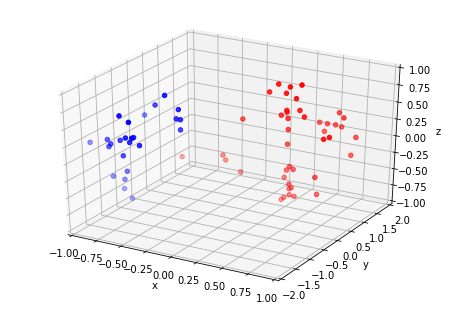

In [7]:
#Test for finding first clusters using milstein_sim_exit and sklearn
fig = plt.figure()
ax = Axes3D(fig)

first_iteration_exits = []
J = len(strata)
for i in xrange(100):
    x = np.random.normal(0., 1.)
    y = np.random.normal(0., 1.)
    z = np.random.normal(0., 1.)
    x_0 = np.array([x,y,z])
    #x_0 = x_0 * 0.3
    #x_0 = np.zeros(3)
    x_0_norm = np.linalg.norm(x_0)
    x_0 = x_0 / max(x_0_norm,1.)
    nu_0_points = [[x_0]]
    nu_0_probs = [[1.]]
    exit_points, exit_times, exit_indices, trajectory_hist = milstein_Sim_Exit(strata, strata_axes, strata_radii, strata_sizes, nu_0_points, nu_0_probs, nu_0_weights, milstein_step)
    first_iteration_exits.append(exit_points[0])
first_iteration_exits = np.array(first_iteration_exits)
Z = ward(pdist(first_iteration_exits))
new_cluster_labels = fcluster(Z, t=strata_sizes[0][1] * 2.5, criterion='distance')
n_new_clusters = max(new_cluster_labels)
new_points = []
for i in xrange(n_new_clusters):
    new_points.append(np.array([first_iteration_exits[k] for k in xrange(100) if new_cluster_labels[k]==i+1]))

#Find the PCA/SVD frame for each cluster, then build new strata
new_strata = []
new_strata_axes = []
new_strata_radii = []
new_strata_sizes = []
for i in xrange(n_new_clusters):
    cluster_mean = np.mean(new_points[i])
    centered_pts = preprocessing.scale(new_points[i], with_mean='True', with_std='False')
    new_strata.append(cluster_mean)
    pca = PCA(n_components=3)
    pca.fit(centered_pts)
    new_strata_axes.append(pca.components_)
    new_strata_radii.append(pca.explained_variance_)

print n_new_clusters
print new_strata
print new_strata_axes


#Example plot for visualizing the clustering of exit points
x_data_1 = new_points[0][:,0]
y_data_1 = new_points[0][:,1]
z_data_1 = new_points[0][:,2]
x_data_2 = new_points[1][:,0]
y_data_2 = new_points[1][:,1]
z_data_2 = new_points[1][:,2]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.,1.)
ax.set_ylim(-2.,2.)
ax.set_zlim(-1.,1.)
ax.scatter3D(x_data_1, y_data_1, z_data_1, c='r')
ax.scatter3D(x_data_2, y_data_2, z_data_2, c='b')